# Analysis of nanosimulations with MDTraj

An initial test with using data from molecule 10v.

In [39]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='.*use @default decorator instead.*')

# MDtraj doesn't have an atomic radius for chlorine, so putting one in.
from mdtraj.geometry.sasa import _ATOMIC_RADII
_ATOMIC_RADII['Cl'] = 0.16

# Loading the trajectory
trajectory = md.load('10v_restarted_trajectory.dcd',top="10v_final.pdb")

## Solvent acessible surface area

In [11]:
sasa = md.shrake_rupley(trajectory)

/Users/rossg/miniconda2/lib/python2.7/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


In [24]:
print('sasa data shape', sasa.shape)
total_sasa = sasa.sum(axis=1)
print(total_sasa.shape)   # This vector has the same number of elements as frames in the trajectory.
print "Average solvent acesccible surface area = %.2f (nm^2)"%total_sasa.mean()

('sasa data shape', (392, 5300))
(392,)
Average solvent acesccible surface area = 185.38 (nm^2)


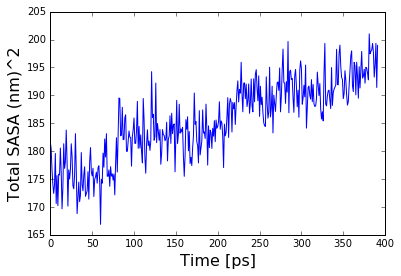

In [43]:
plt.plot(trajectory.time, total_sasa)
plt.xlabel('Time [ps]', size=16)
plt.ylabel('Total SASA (nm)^2', size=16)
plt.show()

#plt.savefig('sasatest.png')
#Image(filename="sasatest.png")


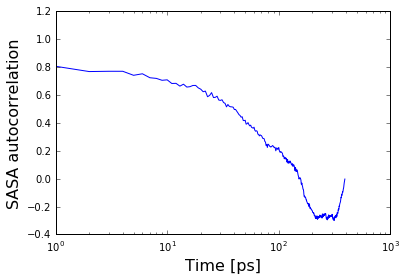

In [38]:
# Looking at the autocorrelation time of SASA:
def autocorr(x):
    "Compute an autocorrelation with numpy"
    x = x - np.mean(x)
    result = np.correlate(x, x, mode='full')
    result = result[result.size//2:]
    return result / result[0]

plt.semilogx(trajectory.time, autocorr(total_sasa))
plt.xlabel('Time [ps]', size=16)
plt.ylabel('SASA autocorrelation', size=16)
plt.show()

#plt.savefig('autocorr.png')
#Image('autocorr.png')

# Radius of gyration

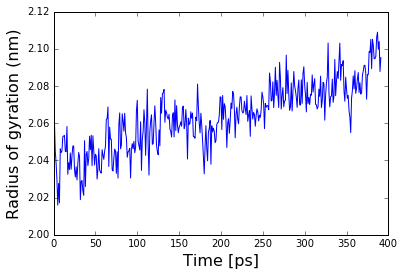

In [44]:
rog = md.compute_rg(trajectory)
plt.plot(trajectory.time, rog)
plt.xlabel('Time [ps]', size=16)
plt.ylabel('Radius of gyration (nm)', size=16)
plt.show()


## Estimating shape

If the nanoparticle is spherical, the radius of gyration should produce a SASA that is roughly 4\*pi\*rog^2.The ratio of the computed SASA and this quantity should be 1 when the nanoparticle is roughly spherical.

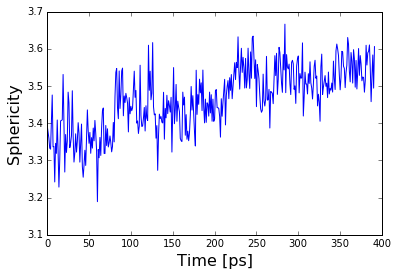

In [48]:
sphericity_10v = total_sasa/(4*np.pi*rog**2)
plt.plot(trajectory.time, sphericity_10v)
plt.xlabel('Time [ps]', size=16)
plt.ylabel('Sphericity', size=16)
plt.show()

Does _sphericity_ capture what is observed in the simulations?

In [50]:
# Loading the trajectory
DIR='/Users/rossg/Work/my_nanoparticles/Production_Implicit_OBC1_longer/'
r4_traj = md.load(DIR+'4r/restarted_trajectory.dcd',top=DIR+"4r_final.pdb")

/Users/rossg/miniconda2/lib/python2.7/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


In [51]:
r4_sasa =  md.shrake_rupley(r4_traj)

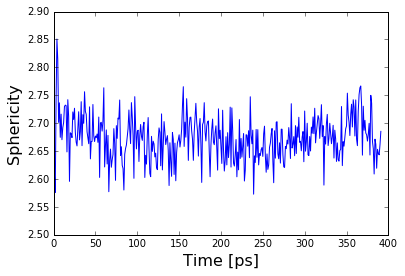

In [52]:
r4_total_sasa = r4_sasa.sum(axis=1)
r4_rog = md.compute_rg(r4_traj)
sphericity_4r = r4_total_sasa/(4*np.pi*r4_rog**2)

plt.plot(trajectory.time, sphericity_4r)
plt.xlabel('Time [ps]', size=16)
plt.ylabel('Sphericity', size=16)
plt.show()

Because this value is closer to 1, this suggests that 4r is more spherical than 10v, which does not appear to be true when looking at the simulations.

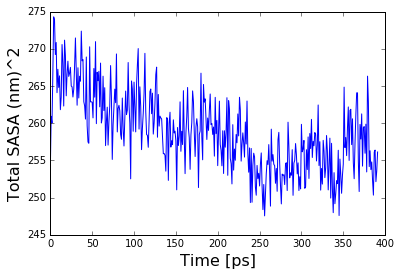

In [53]:
# Looking at 4r SASA...
plt.plot(r4_traj.time, r4_total_sasa)
plt.xlabel('Time [ps]', size=16)
plt.ylabel('Total SASA (nm)^2', size=16)
plt.show()

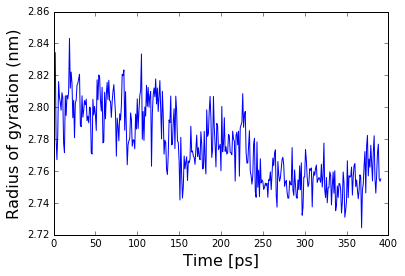

In [54]:
# And radis of gyration.
plt.plot(r4_traj.time, r4_rog)
plt.xlabel('Time [ps]', size=16)
plt.ylabel('Radius of gyration (nm)', size=16)
plt.show()

It seems I need is a better definition for _sphericity_. Wikipedia has decent definition:

$$\Psi = \frac{\pi^{\frac{1}{3}}(6V)^{\frac{2}{3}}}{A}$$

The only problem is that's is difficult to calculate volume...

In [ ]:
trajectory.